In [1]:
import json

with open("reference.json", "r") as f:
    data = json.load(f)

In [2]:
len(data['paths'].keys())

122

## FIRST LEVEL

In [3]:
l = []
for path in data['paths'].keys():
    l.append(path.split("/")[1])

paths_list = list(set(l))

In [4]:
data['routers']

{'/crypto': {'description': 'Cryptocurrency market data.'},
 '/currency': {'description': 'Foreign exchange (FX) market data.'},
 '/derivatives': {'description': 'Derivatives market data.'},
 '/economy': {'description': 'Economic data.'},
 '/equity': {'description': 'Equity market data.'},
 '/etf': {'description': 'Exchange Traded Funds market data.'},
 '/fixedincome': {'description': 'Fixed Income market data.'},
 '/index': {'description': 'Indices data.'},
 '/news': {'description': 'Financial market news data.'},
 '/regulators': {'description': 'Financial market regulators data.'}}

In [12]:
routers_names = [r.split("/")[1] for r in data['routers']]

In [15]:
'/crypto/price/historical'.split("/")

['', 'crypto', 'price', 'historical']

In [16]:
router_specific_paths = {k:[] for k in routers_names}
for paths in data['paths']:
    req_router = paths.split("/")[1]
    router_specific_paths[req_router].append(paths)    

In [64]:
with open("openbb_functions_enum.json", "r") as f:
    openbb_functions = json.load(f)

In [65]:
openbb_functions[0]

{'name': 'obb_crypto_price_historical',
 'description': 'Get historical price data for cryptocurrency pair(s) within a provider.',
 'parameters': {'type': 'object',
  'properties': {'symbol': {'type': 'string',
    'description': 'Symbol to get data for. Can use CURR1-CURR2 or CURR1CURR2 format. Multiple items allowed for provider(s): fmp, polygon, tiingo, yfinance.',
    'default': ''},
   'start_date': {'type': 'string',
    'description': 'Start date of the data, in YYYY-MM-DD format.',
    'default': None},
   'end_date': {'type': 'string',
    'description': 'End date of the data, in YYYY-MM-DD format.',
    'default': None},
   'provider': {'description': "The provider to use for the query, by default None. If None, the provider specified in defaults is selected or 'fmp' if there is no default.",
    'default': 'fmp',
    'type': 'string',
    'enum': ['fmp', 'polygon', 'tiingo', 'yfinance']}},
  'required': ['symbol', 'provider']}}

In [66]:
openbb_functions_name_dict = {k['name']:k for k in openbb_functions}

In [121]:
s = "Literal['intrinio']"
s[s.find("[")+2:s.find("]")-1]

'intrinio'

In [142]:
import networkx as nx
from typing import List


def get_graph(router_name:str,router_specific_paths_names:List[str]):
# router_name = 'crypto'
    desc = data['routers']['/'+router_name]
    G = nx.DiGraph()
    G.add_nodes_from([(router_name,{"description":desc})])
    for router_paths in router_specific_paths_names:
        router_path_split = router_paths.split("/")[1:]
        func_name = router_paths.split("/")[1:]
        func_name = "obb_" + "_".join(func_name)
        # print(router_path_split)
        if len(router_path_split)>2:
            if not G.has_node(router_path_split[1]):
                G.add_nodes_from([(router_path_split[1],{"description": f"This node has information about {router_path_split[1]}"})])
                G.add_edge(router_name,router_path_split[1])
                # print(openbb_functions_name_dict[func_name])
            if func_name not in openbb_functions_name_dict:
                provider_parameters = data['paths'][router_paths]['parameters']['standard']
                # print(provider_parameters)
                for pp in provider_parameters:
                    if pp['name'] == 'provider':
                        real_provider = pp['type'][pp['type'].find("[")+2:pp['type'].find("]")-1]
                        func_name+='_'+real_provider
                G.add_nodes_from([(func_name,{'function_call':openbb_functions_name_dict[func_name]})])
                G.add_edge(router_path_split[1],func_name)
            else:
                provider_names = openbb_functions_name_dict[func_name]['parameters']['properties']['provider']['enum'] 
                provider_func_names = [func_name+"_"+provider for provider in provider_names]
                G.add_nodes_from([(router_path_split[2],{'function_call':openbb_functions_name_dict[func_name]})])
                G.add_edge(router_path_split[1],router_path_split[2])
                for provider_funcs in provider_func_names:
                    G.add_nodes_from([(provider_funcs,{'function_call':openbb_functions_name_dict[provider_funcs]})])
                    G.add_edge(router_path_split[2],provider_funcs)
        elif len(router_path_split)<3:
            for openbb_fn_names in openbb_functions_name_dict:
                if openbb_fn_names.rpartition('_')[0] == func_name:
                    G.add_nodes_from([(func_name,{"function_call": openbb_functions_name_dict[openbb_fn_names]})])
                    G.add_edge(router_name,func_name)
                    break
    return G

router_names_graph = {k:get_graph(k,router_specific_paths[k]) for k in routers_names}

In [143]:
router_names_graph['currency'].nodes

NodeView(('currency', 'price', 'historical', 'obb_currency_price_historical_fmp', 'obb_currency_price_historical_polygon', 'obb_currency_price_historical_tiingo', 'obb_currency_price_historical_yfinance', 'obb_currency_search', 'obb_currency_snapshots'))

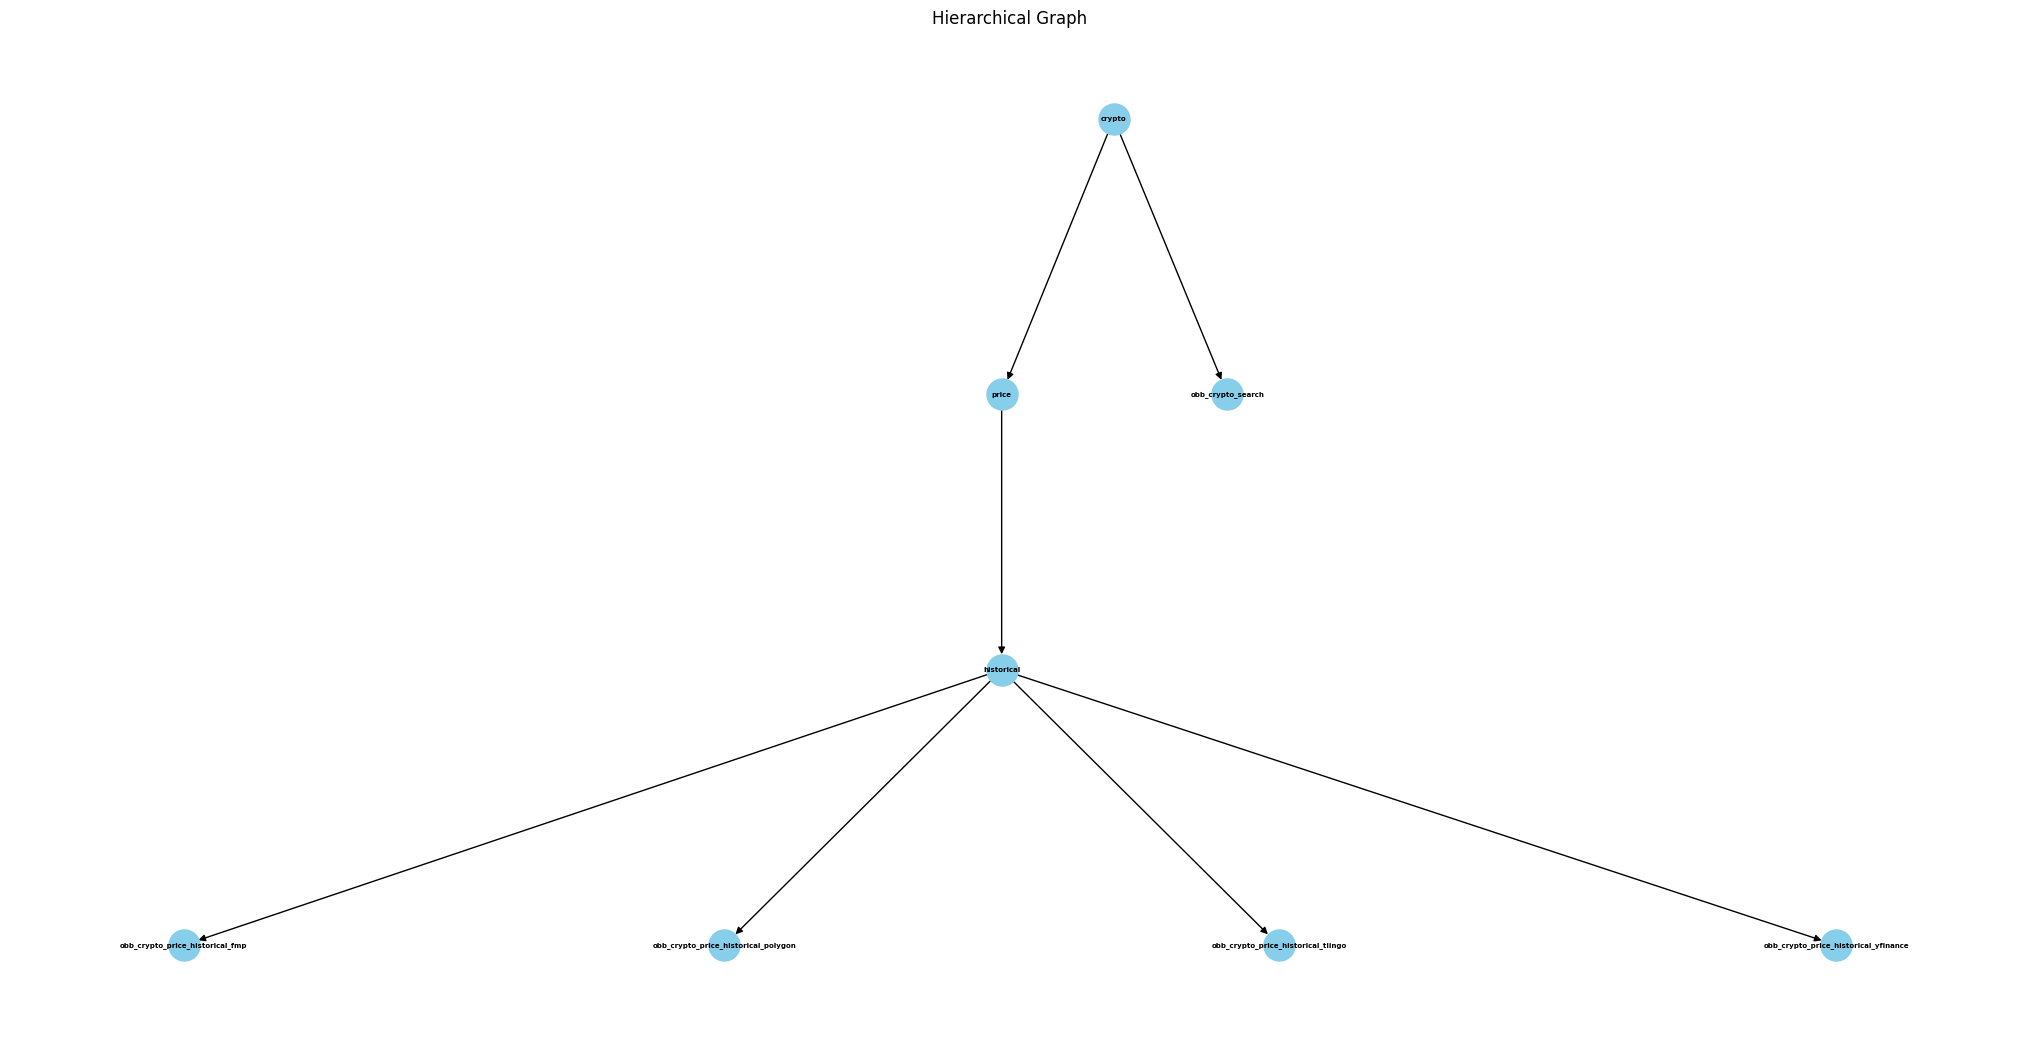

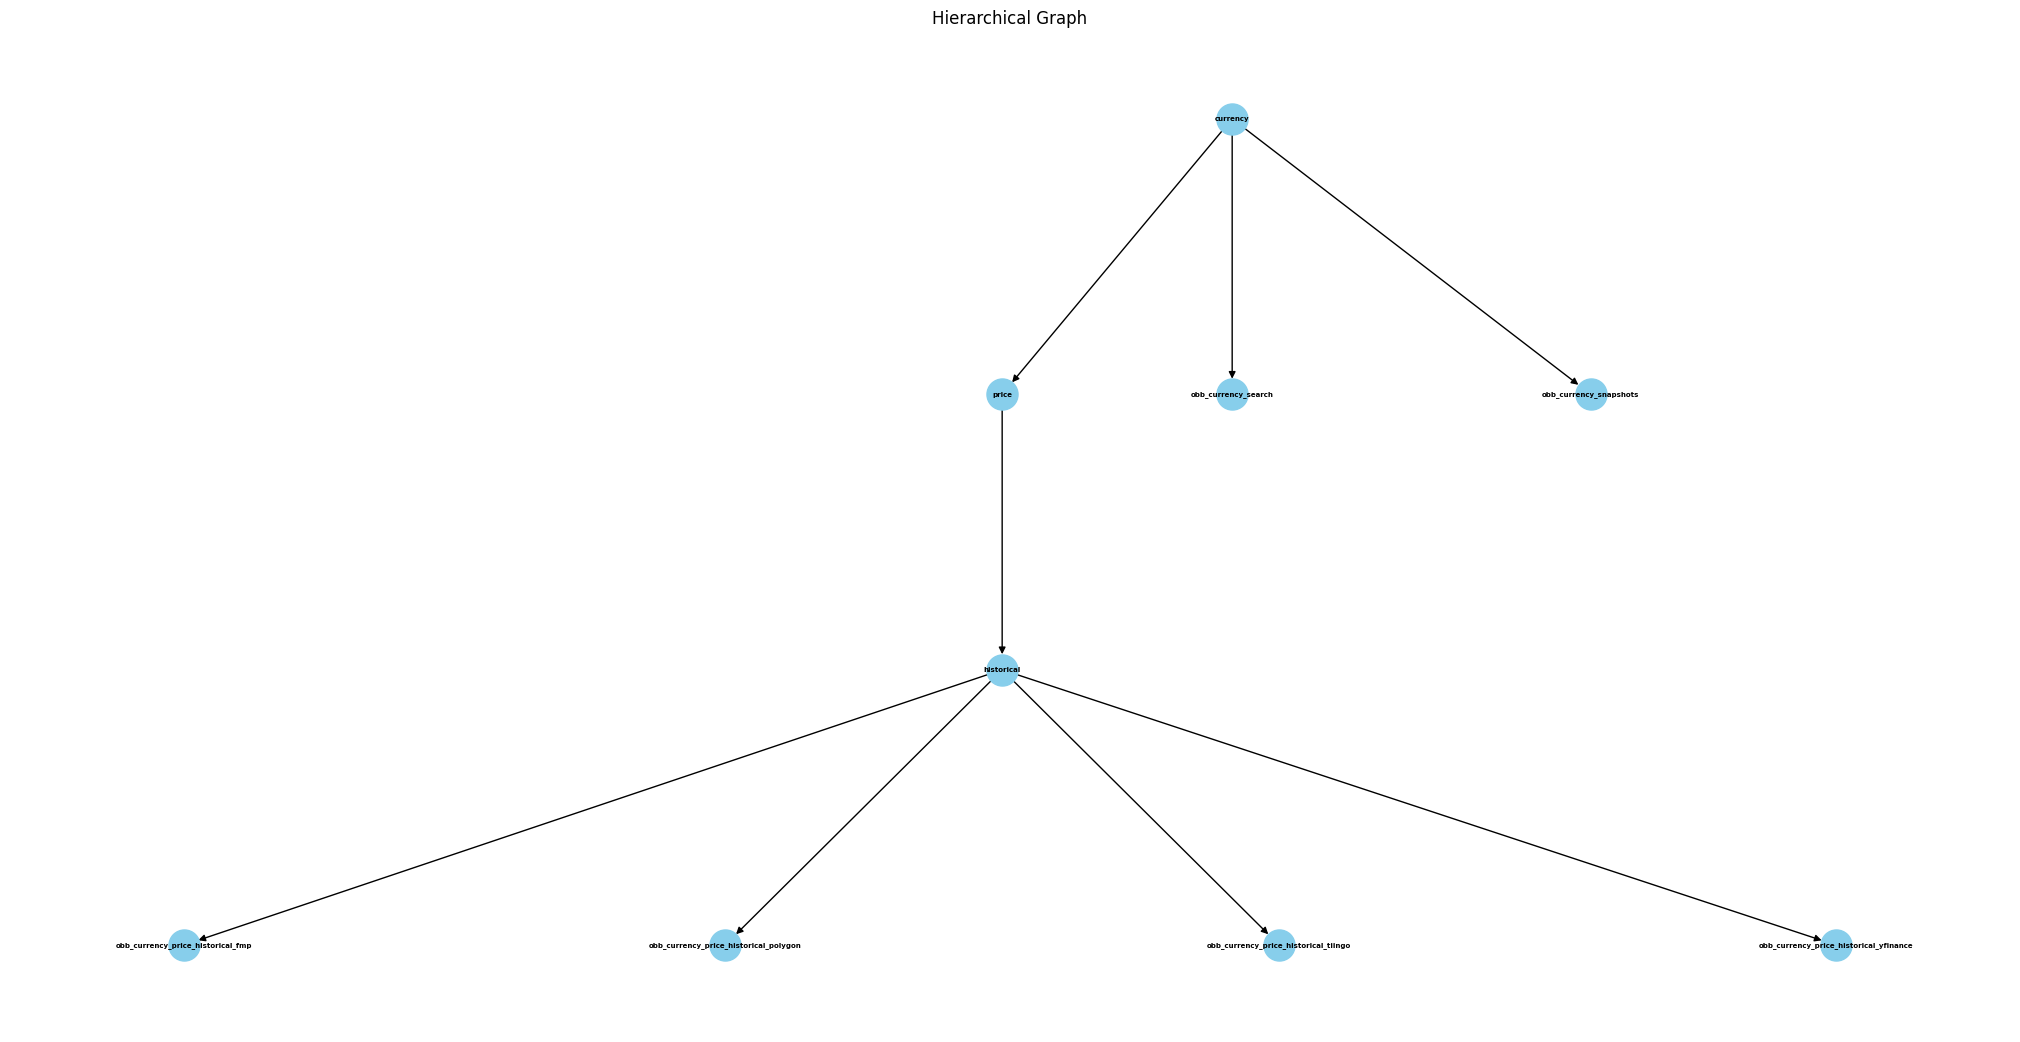

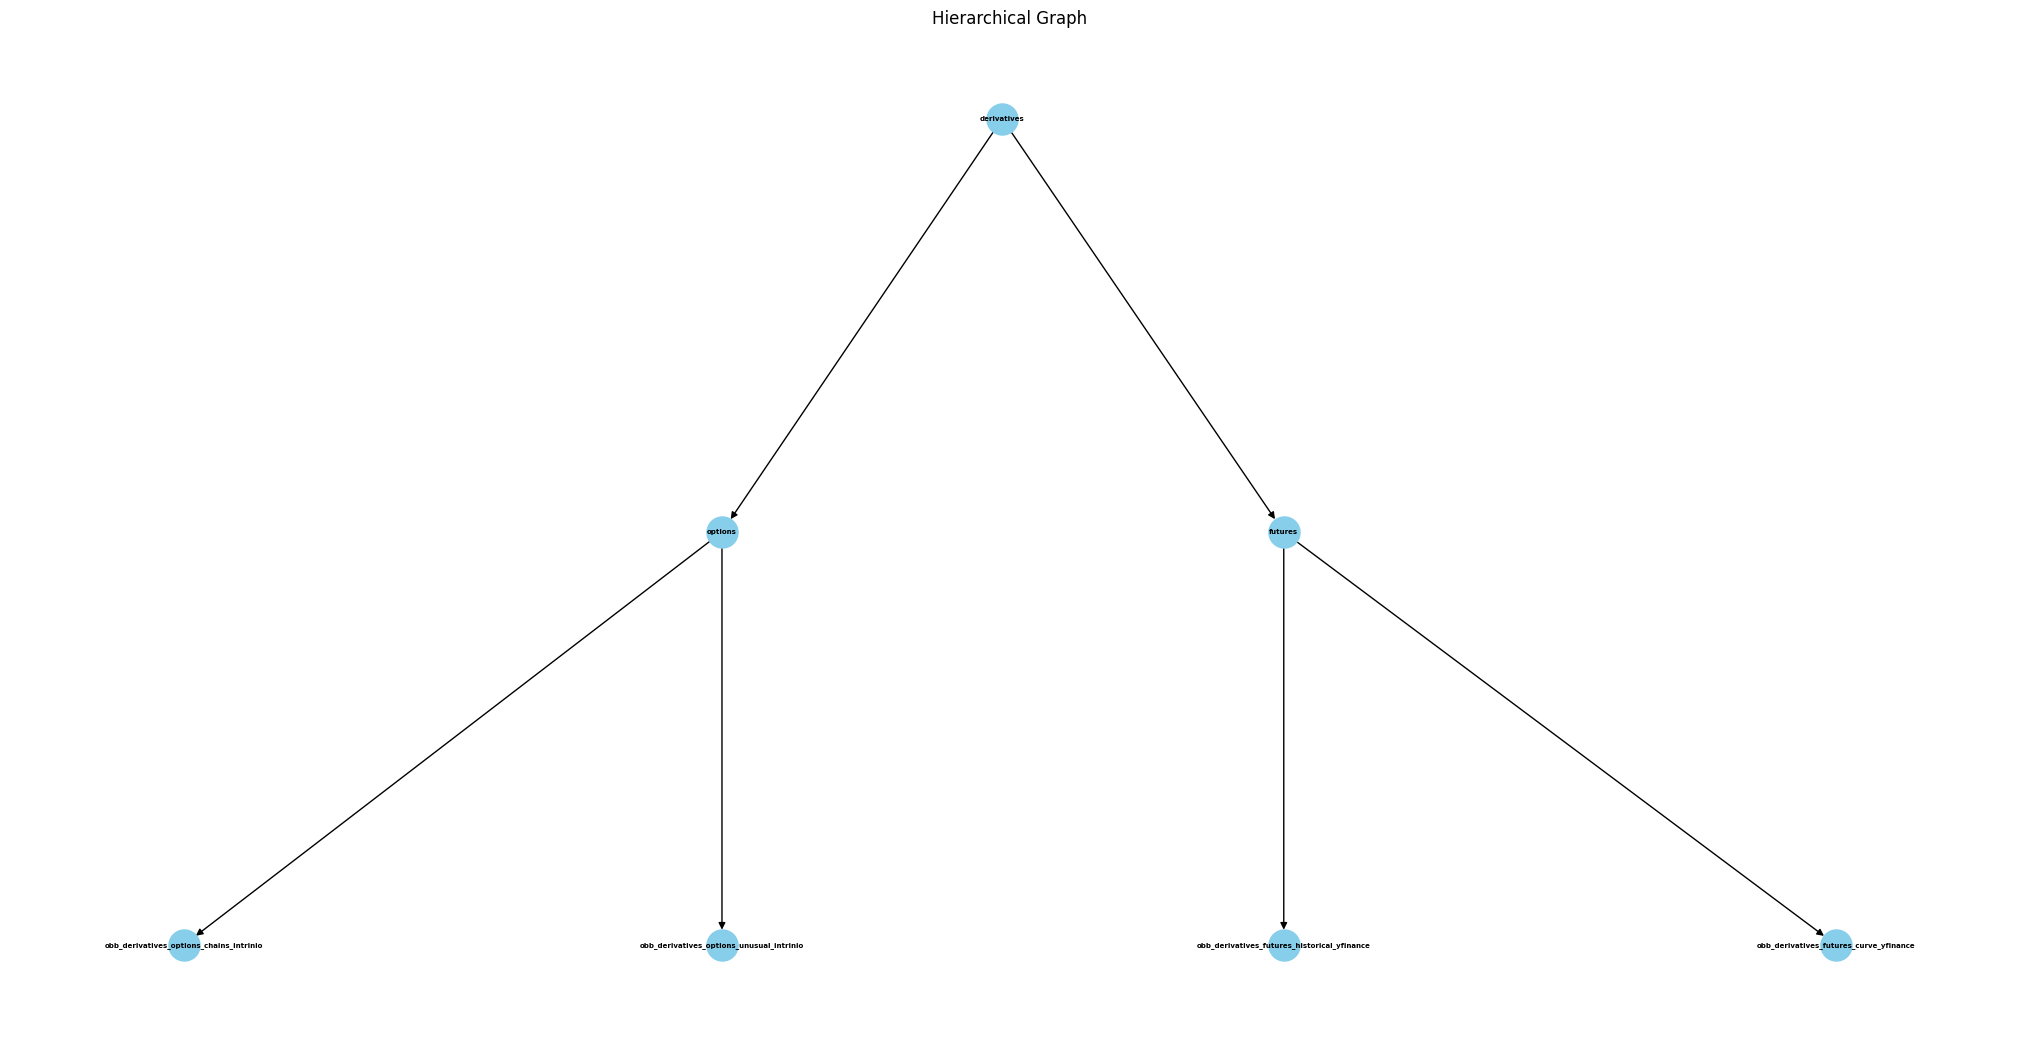

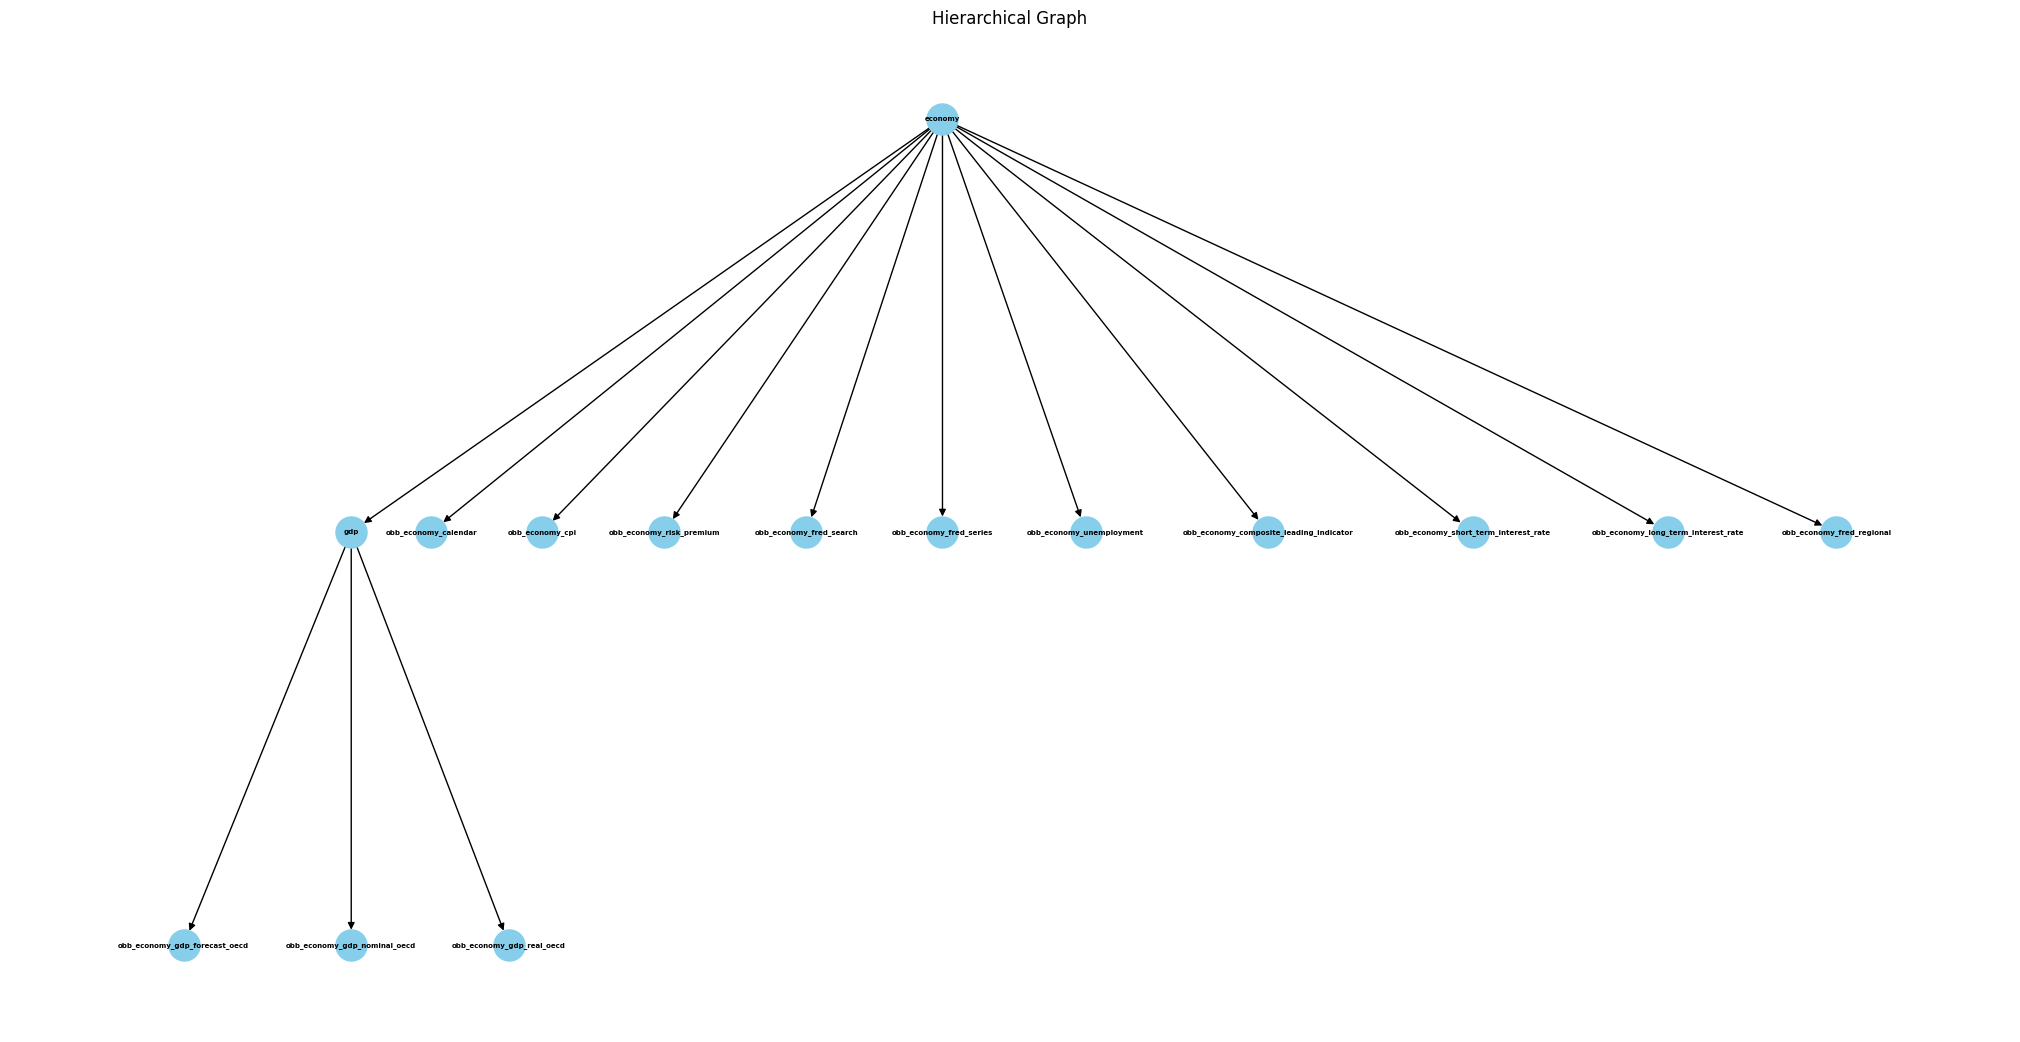

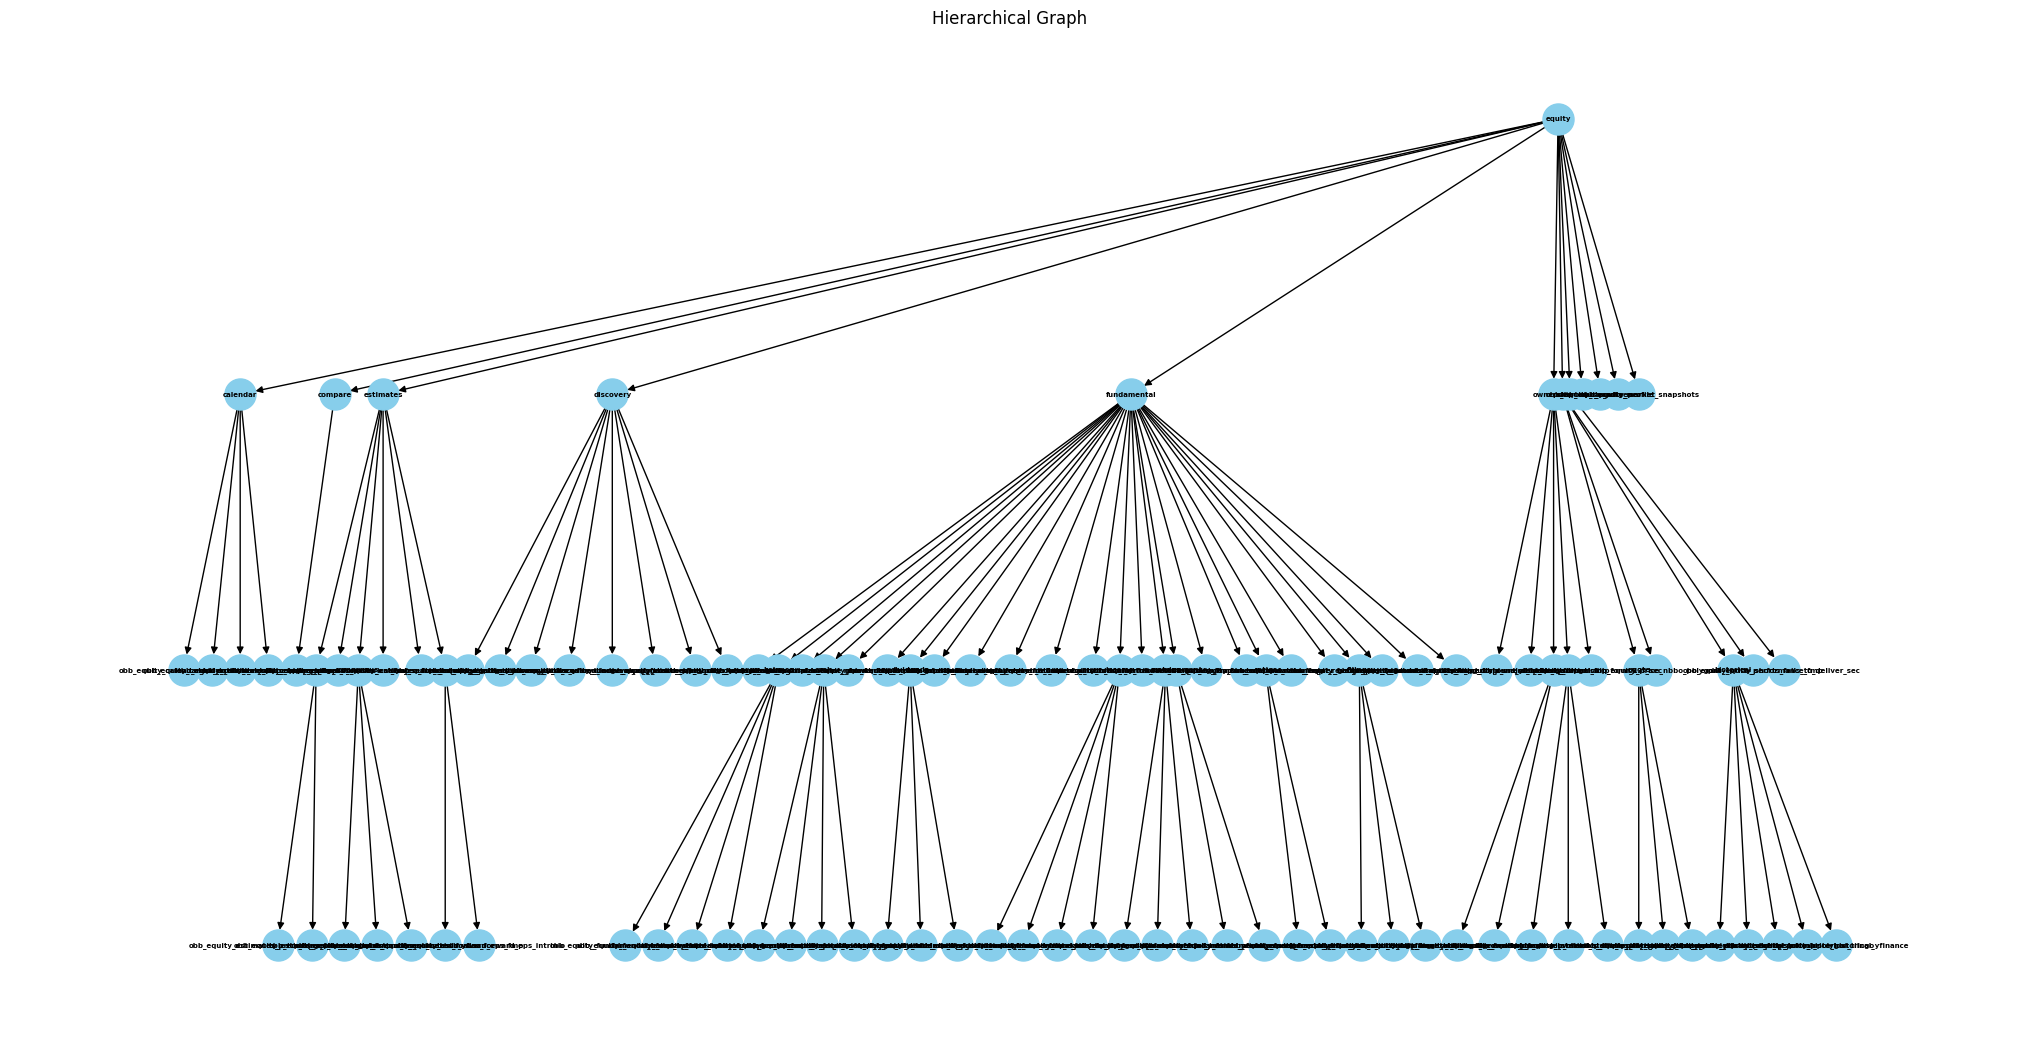

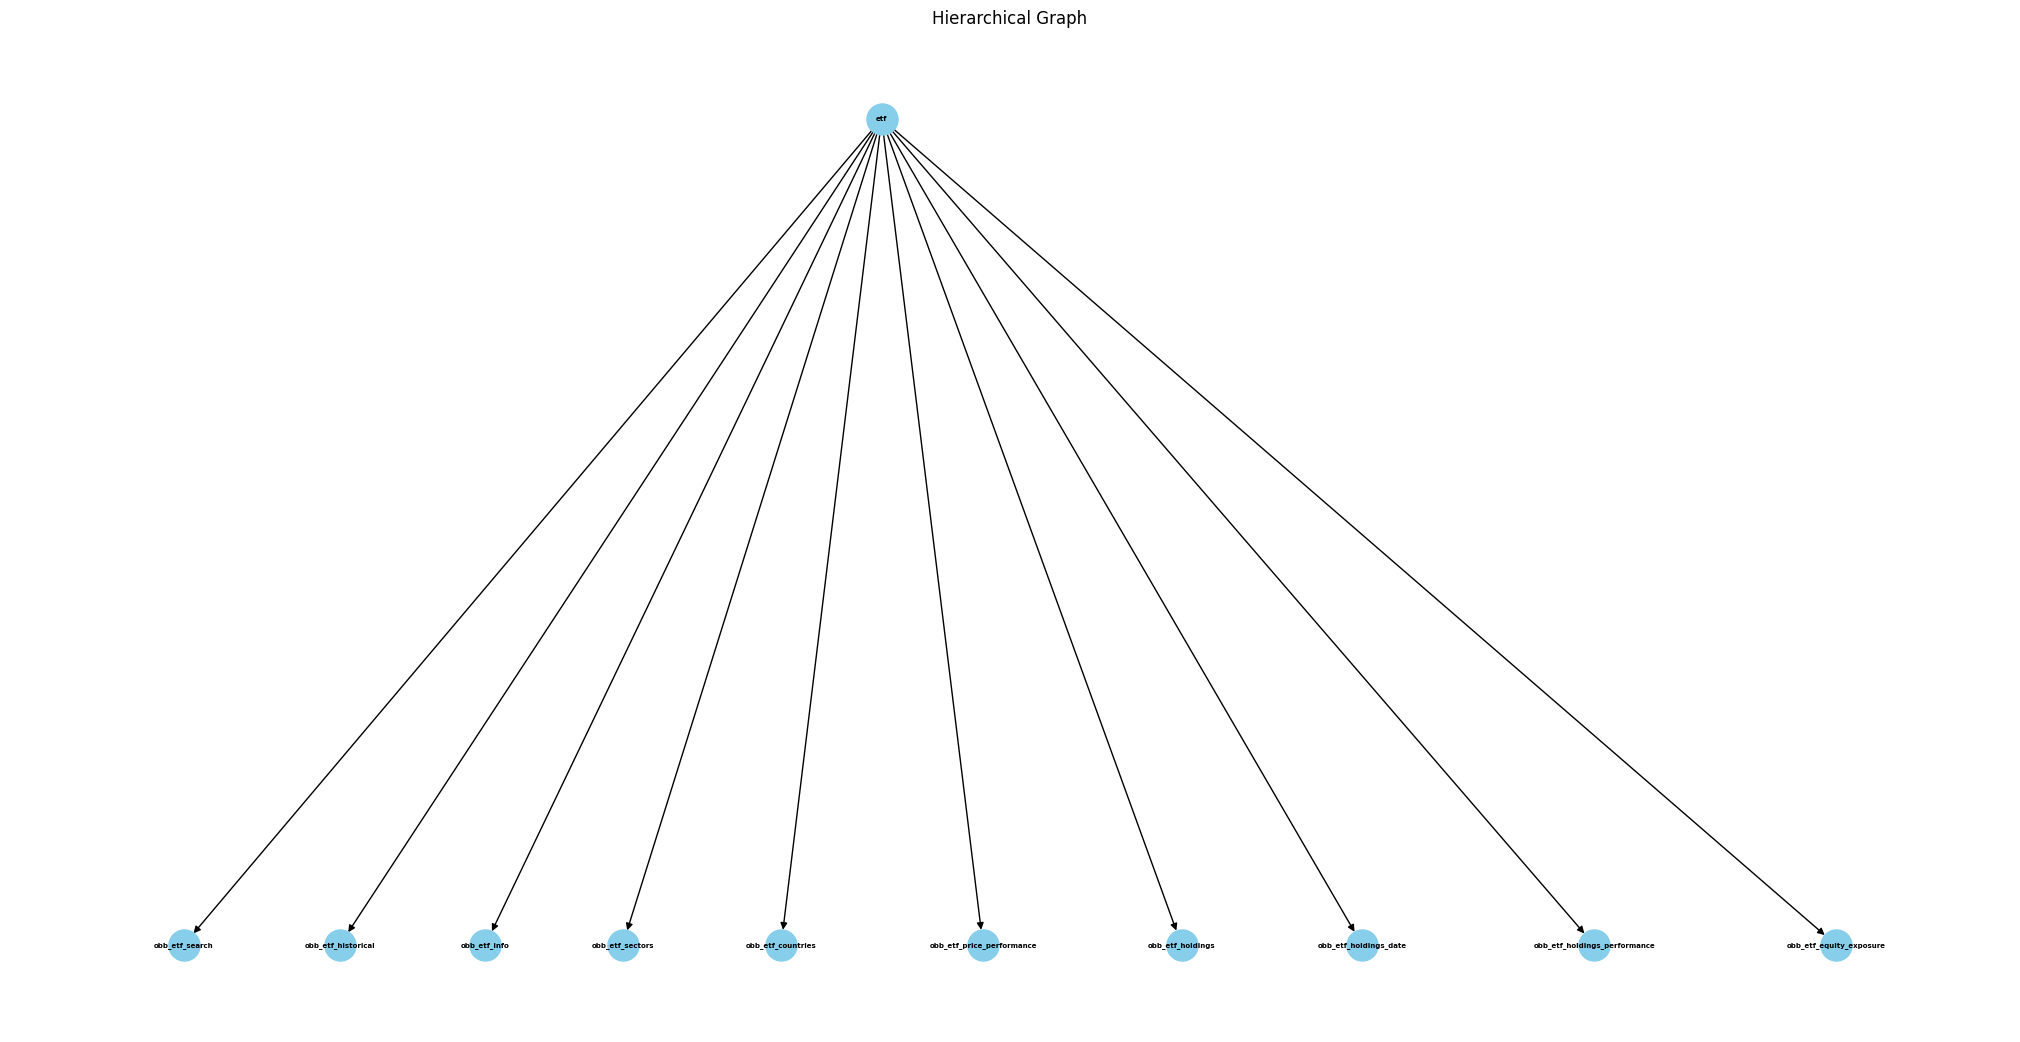

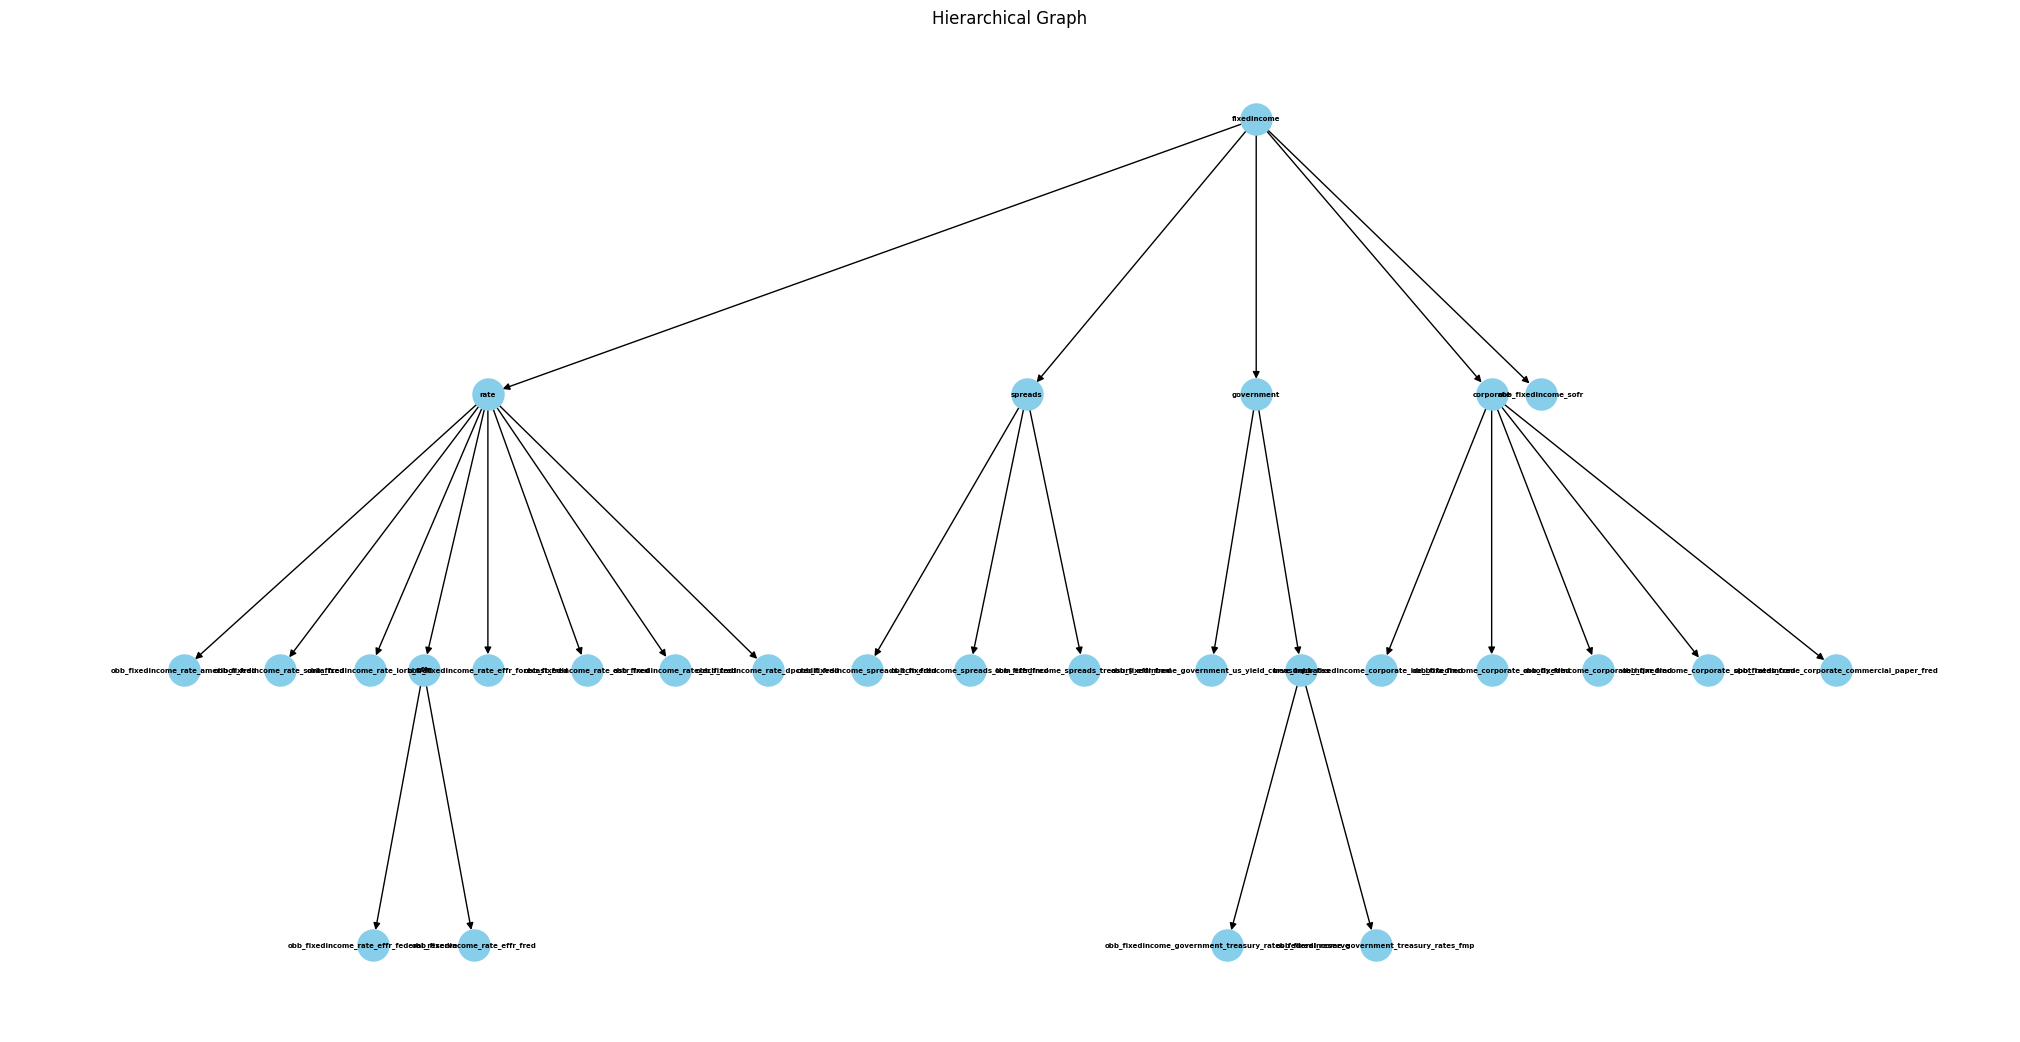

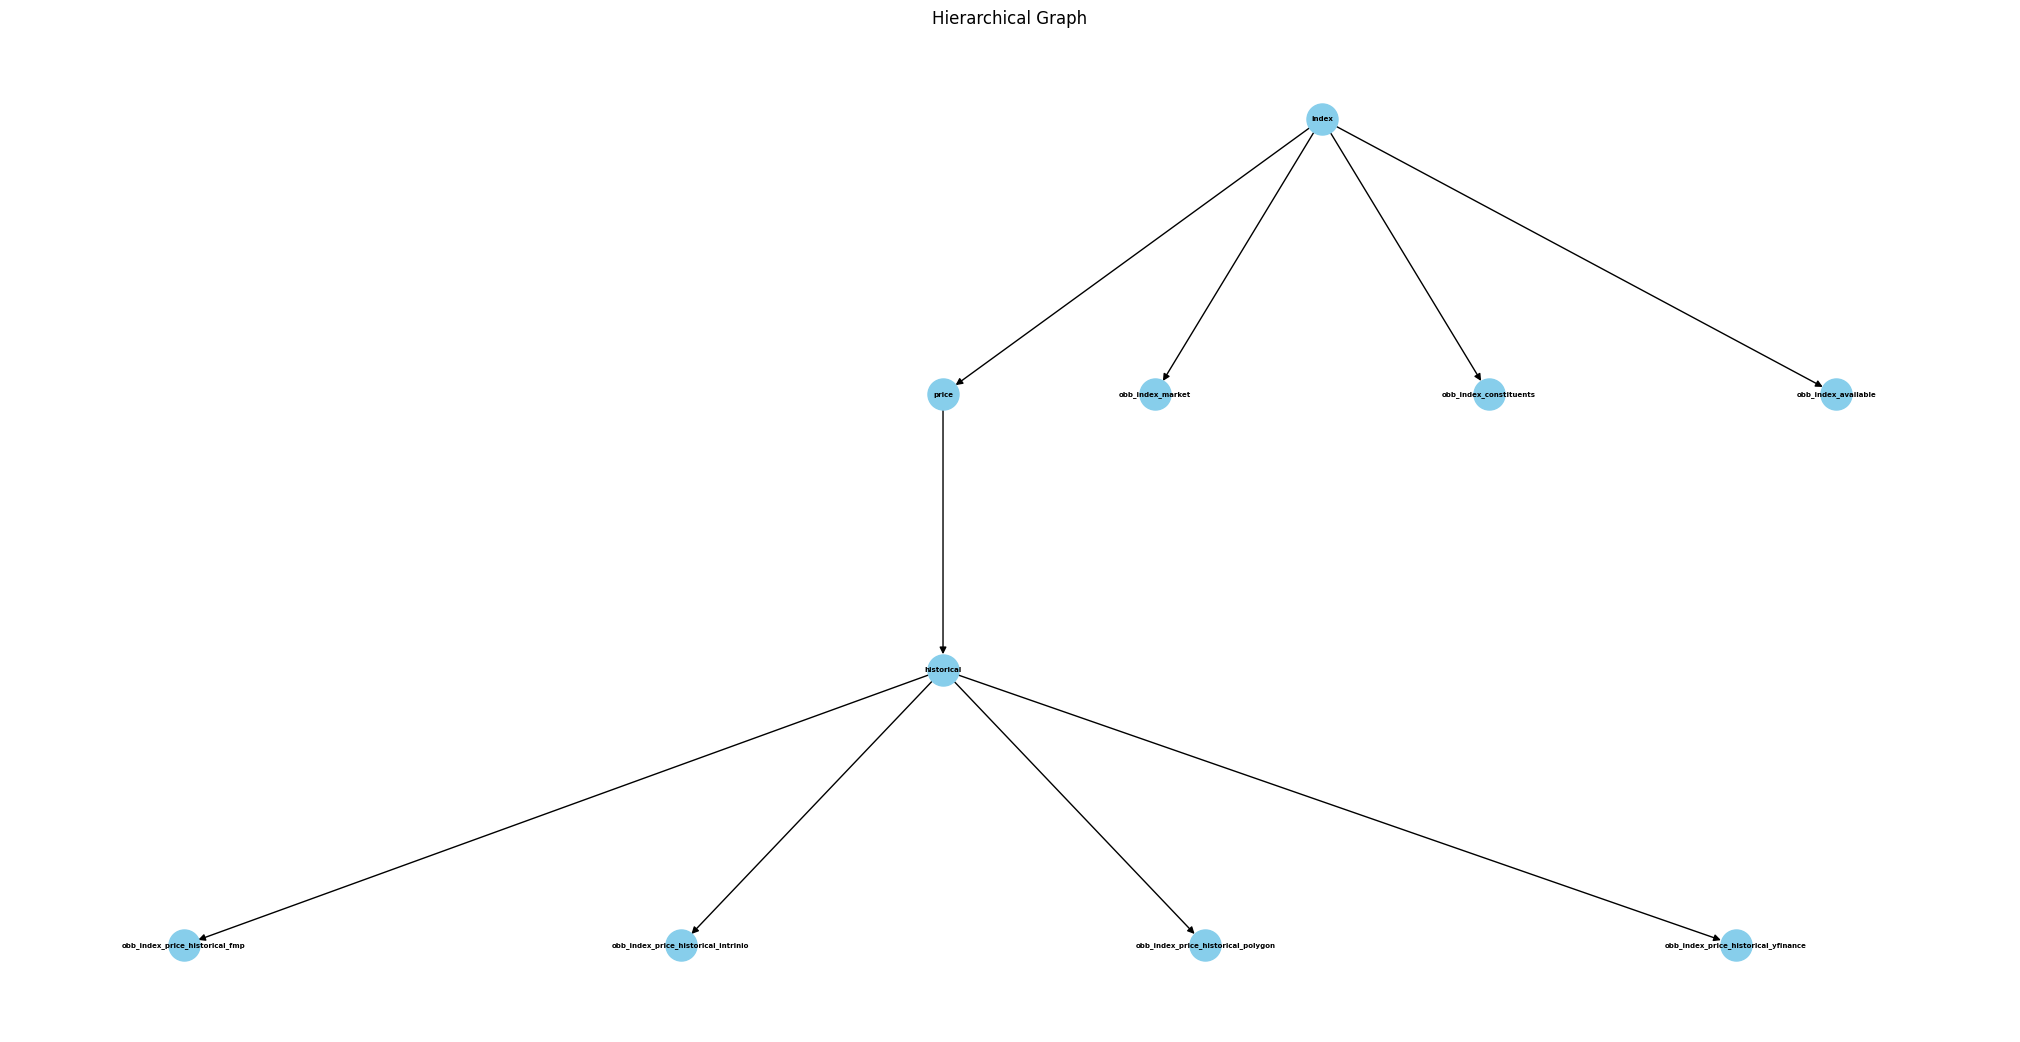

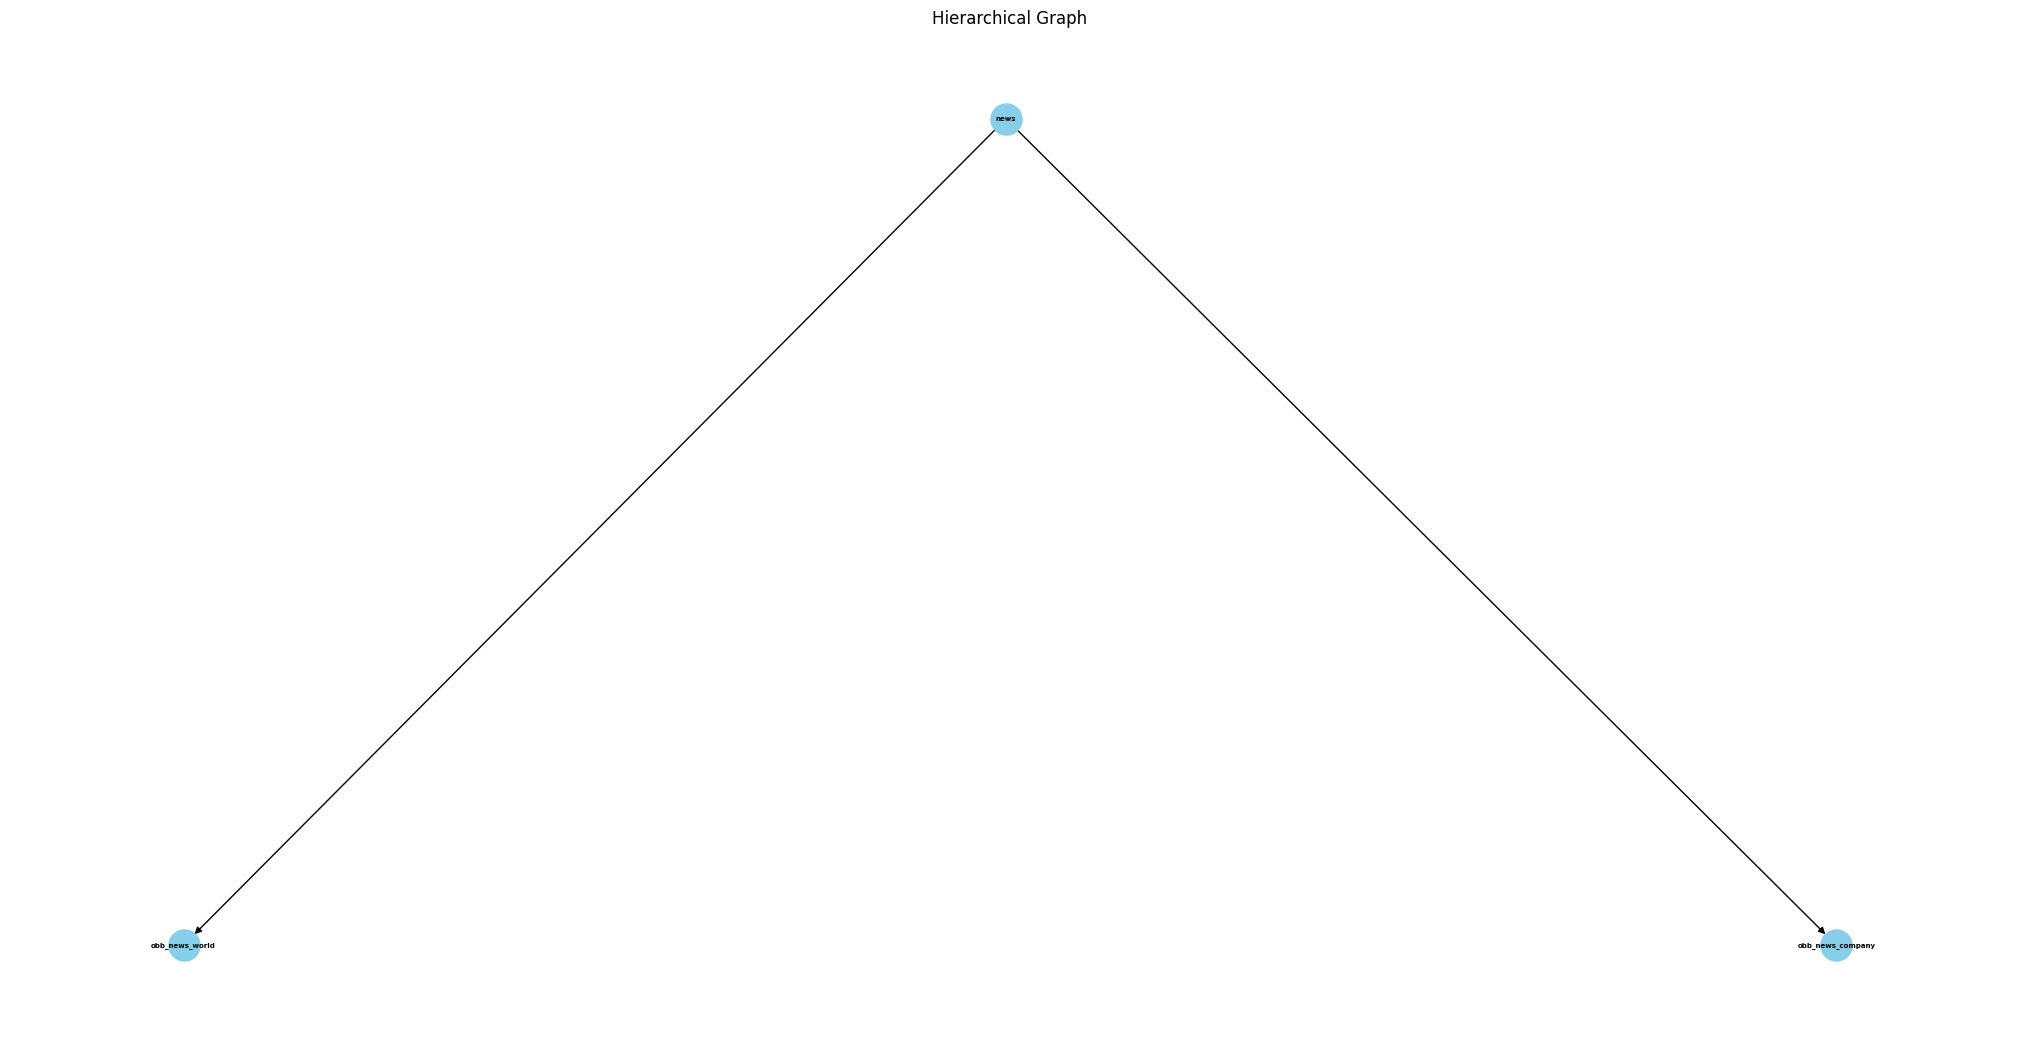

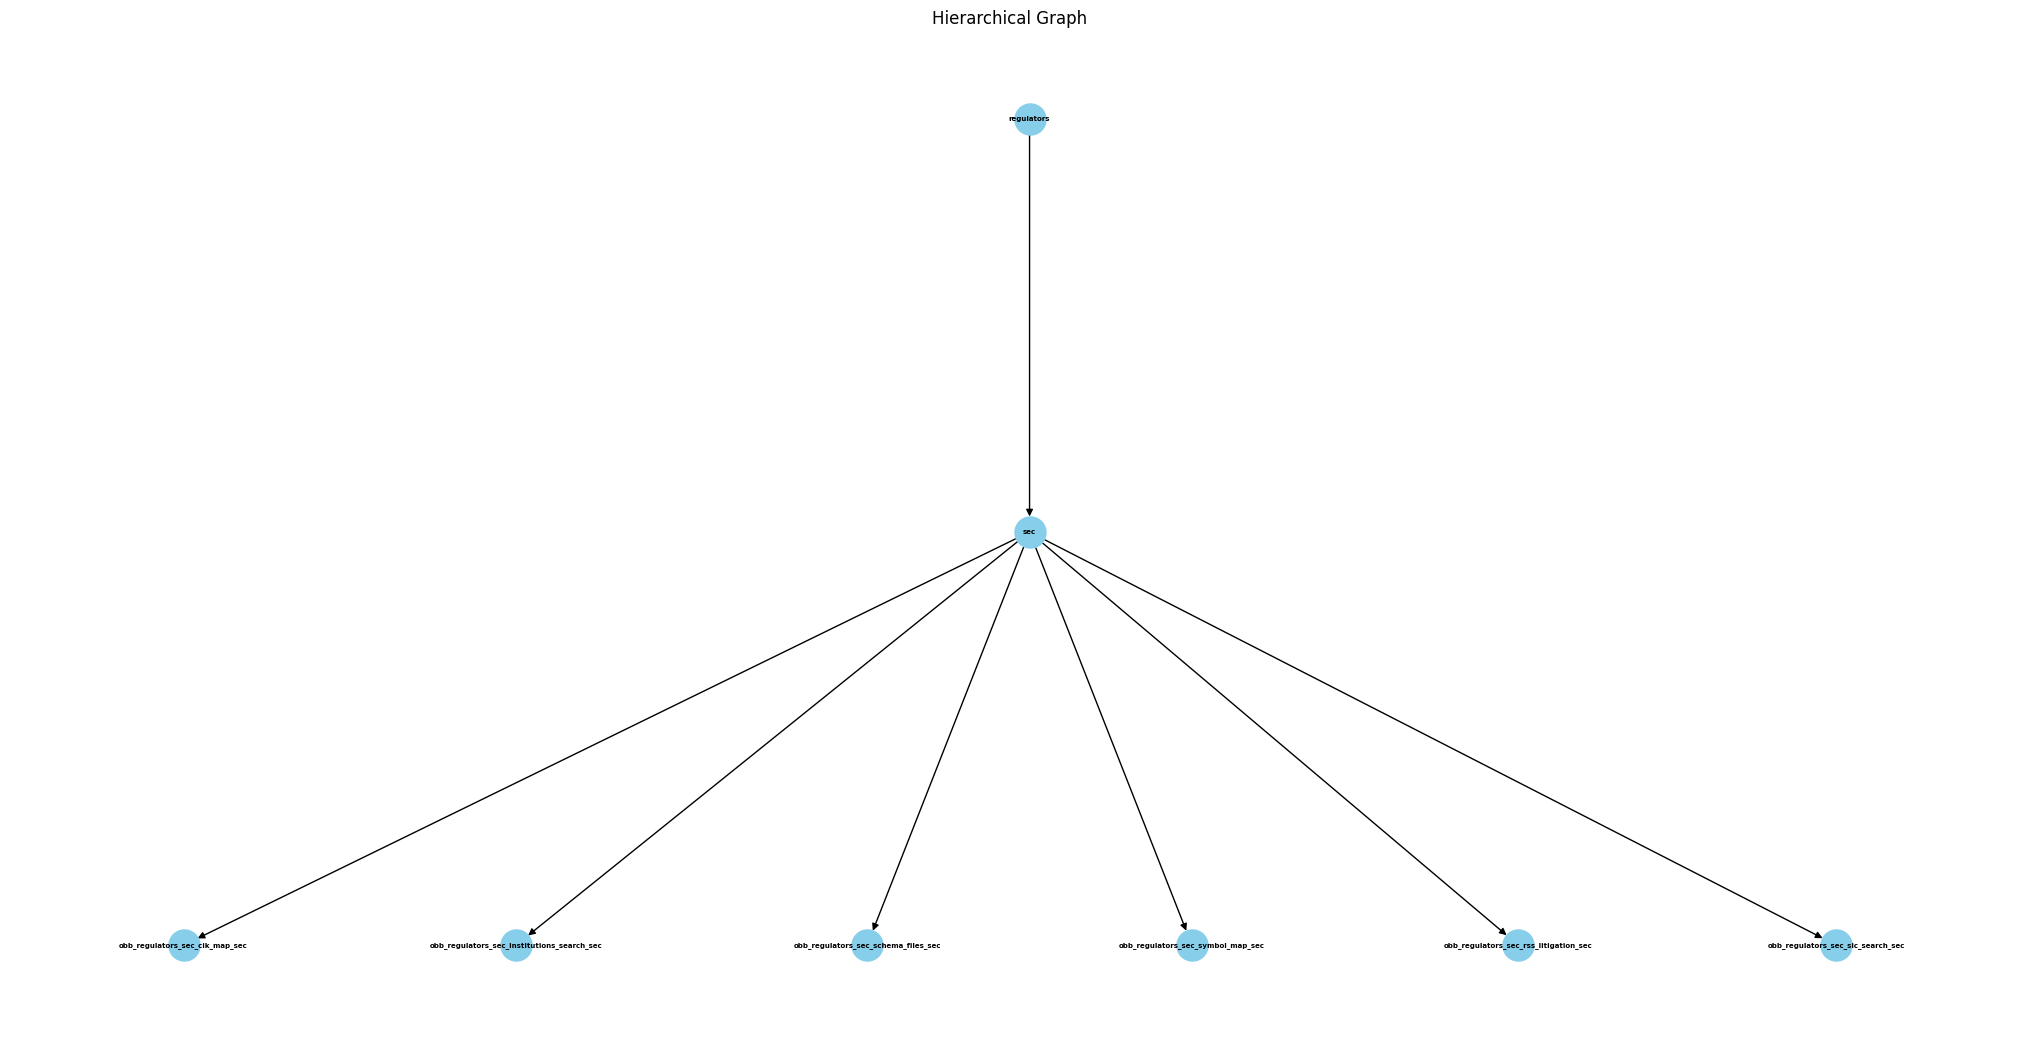

In [148]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
for router in routers_names:
    graph = router_names_graph[router]
    pos = graphviz_layout(graph, prog="dot")
    plt.figure(figsize=(20, 10))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=5, font_weight="bold", arrows=True)
    plt.title("Hierarchical Graph")
    plt.show()

## SECOND LEVEL

In [47]:
import networkx as nx
G = nx.DiGraph()
G.add_node("openbb")
for pl in paths_list:
    G.add_edge('openbb',pl)
G.add_nodes_from(paths_list)
first_level_dict = {k:[] for k in paths_list}
# second_level_dict = {k:[] for k in paths_list}
for path in data['paths'].keys():
    covered_nodes = []
    path_split = path.split("/")[1:]
    if len(path_split) == 3:
        # first_level_dict[path_split[0]].append(f"{path_split[1]}-->{path_split[2]}")
        first = path_split[0]
        second = path_split[1]
        third = path_split[2]
        third = second + "/" + third
        G.add_node(third)
        if second in covered_nodes:
            G.add_edge(second, third)
        else:
            G.add_edge(first, second)
            covered_nodes.append(second)
            G.add_node(second)
            G.add_edge(second, third)
    else:
        second = path_split[1]
        covered_nodes.append(second)
        G.add_node(second)
        G.add_edge(first,second)
        

In [48]:
G.nodes

NodeView(('openbb', 'equity', 'currency', 'economy', 'etf', 'fixedincome', 'regulators', 'crypto', 'derivatives', 'index', 'news', 'price/historical', 'price', 'search', 'snapshots', 'options/chains', 'options', 'options/unusual', 'futures/historical', 'futures', 'futures/curve', 'gdp/forecast', 'gdp', 'gdp/nominal', 'gdp/real', 'calendar', 'cpi', 'risk_premium', 'fred_search', 'fred_series', 'money_measures', 'unemployment', 'composite_leading_indicator', 'short_term_interest_rate', 'long_term_interest_rate', 'fred_regional', 'calendar/ipo', 'calendar/dividend', 'calendar/splits', 'calendar/earnings', 'compare/peers', 'compare', 'estimates/price_target', 'estimates', 'estimates/historical', 'estimates/consensus', 'estimates/analyst_search', 'estimates/forward_sales', 'estimates/forward_eps', 'discovery/gainers', 'discovery', 'discovery/losers', 'discovery/active', 'discovery/undervalued_large_caps', 'discovery/undervalued_growth', 'discovery/aggressive_small_caps', 'discovery/growth_t

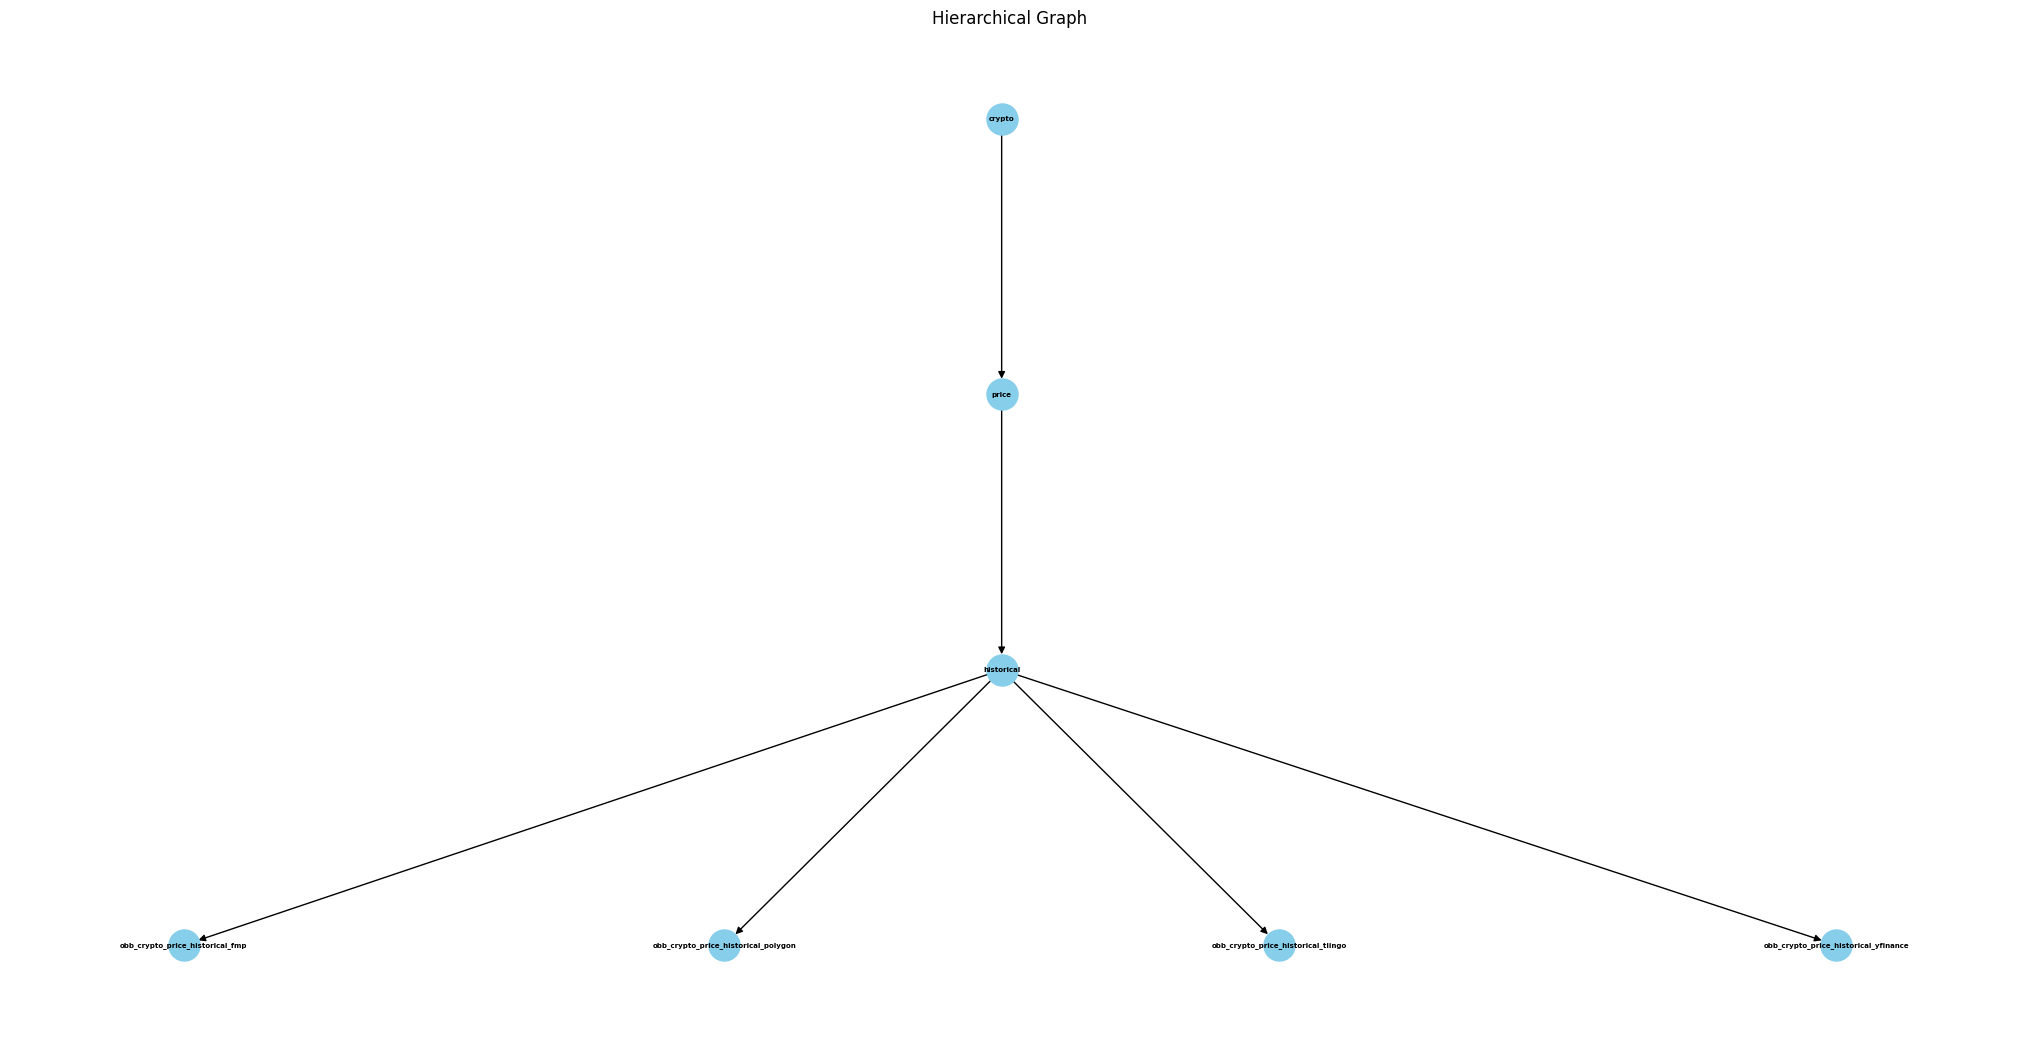